# Warren & Root (1963) interpretation  
 
This notebook demonstrates how to use **OpenHyTest** for the interpretation of a pumping test with the Warren & Root (1963) solution for double porosity aquifer.

Copyright 1998-2020 - Philippe Renard, Nathan Dutler & Bernard Brixel

First, we append the openhytest folder to the system path using the 'sys' library and import than the 'openhytest' library as ht. In addition, we import the 'matplotlib.pyplot' library for plotting and the 'pandas' library for data management.


In [1]:
%matplotlib inline
import sys
sys.path.append("..")
import openhytest as ht
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import mpmath as mp
from scipy.special import expn as E1

## Model

A set of Warren & Root type curves for different values of $\lambda$ and $\sigma$ in logarithmic scale.

Usual values for $\lambda$ are between 10−4 and 10−10, and usual value for $\sigma$ are between 10 and 1000. 
$\sigma$ relates the amount of water available in the matrix with respect to the amount available in the fractures. 
$\lambda$ relates to the properties controlling the exchange between the matrix and the fractures. When $\lambda$ is high, the exchange is
fast. When $\lambda$ is small the exchange is slow.

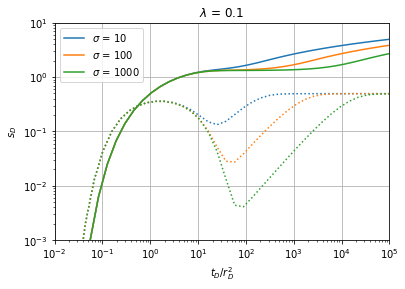

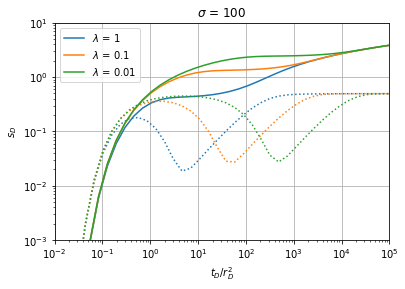

In [2]:
warren = ht.WarrenRoot()
warren.plot_typecurve()

The type curves of $s_D$ as a function of $t_D/r^2$ , shows a S-shape curve with three distinct phases corresponding to early time, intermediate time and late time. The following plot show the early and late time Theis

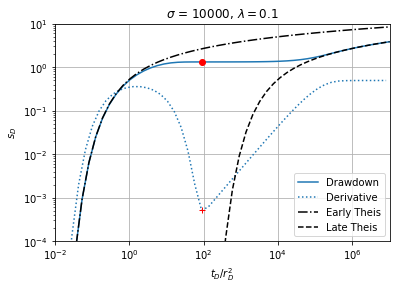

In [3]:
warren.landa = 0.1
warren.sigma = 10000
td = np.logspace(-2, 7)
fig, ax = plt.subplots(1,1)
omega = 1 / (1 + warren.sigma)
sd = list(warren._laplace_drawdown_types(td))
d = {'t': td, 's': sd}
df = pd.DataFrame(data=d)
dummy = ht.preprocessing(df=df)
dummy.ldiff()
color = next(ax._get_lines.prop_cycler)['color']
ax.loglog(td, sd, '-', color=color, label= 'Drawdown')
ax.loglog(dummy.der.t, dummy.der.s, ':', color=color, label= 'Derivative')

# Theis approximation
theis = ht.Theis()
s1 = theis.dimensionless(td)
s2 = theis.dimensionless(omega*td)
ax.loglog(td, s1, 'k-.', label= 'Early Theis')
ax.loglog(td, s2, 'k--', label= 'Late Theis')

# Plot derivatiave minimum 
tmin = np.log(1+warren.sigma)/warren.landa
dsmin = (1+omega**(1/(1-omega))-omega**(omega/(1-omega)))/2
smin = mp.besselk(0,mp.sqrt(warren.landa))
ax.loglog(tmin, dsmin, 'r+')
ax.loglog(tmin, smin, 'ro')

plt.xlabel('$t_D / r_D^2$')
plt.ylabel('$s_D$')
plt.title('$\sigma$ = {}, $\lambda = {}$'.format(warren.sigma, warren.landa))
plt.legend()
plt.xlim((1e-2, 1e7))
plt.ylim((1e-4, 10))
plt.grid('True')
plt.legend()
plt.show()

The following approximation is able to fit the Root & Warren model with best match at intermediate and late time and is implemented in openhytest in the function fit_approximation.

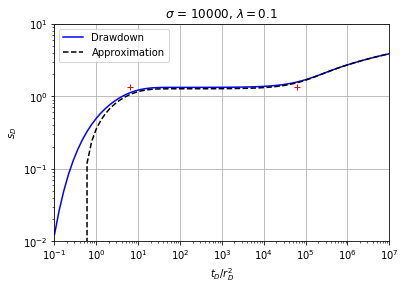

In [4]:
warren.sigma=10000
omega=1/(1+warren.sigma)
warren.landa=0.1
fig, ax = plt.subplots(1,1)

t = np.logspace(-1,10,100)
sd = warren._laplace_drawdown_types(t)

sp = mp.besselk(0,mp.sqrt(warren.landa))
t1 = mp.exp(2*mp.besselk(0,mp.sqrt(warren.landa))+0.577215)/4
t2 = t1*(1+warren.sigma)
sap = 0.5*(np.log(t*4/(1+warren.sigma))-0.5772-E1(1,warren.landa*(1+warren.sigma)*t/warren.sigma)+E1(1,warren.landa*t/warren.sigma)) 

ax.loglog(t, sd, '-b', label= 'Drawdown')
ax.loglog(t, sap, '--k', label= 'Approximation')
ax.loglog(t1, sp, '+r')
ax.loglog(t2, sp, '+r')

plt.xlabel('$t_D / r_D^2$')
plt.ylabel('$s_D$')
plt.title('$\sigma$ = {}, $\lambda = {}$'.format(warren.sigma, warren.landa))
plt.legend()
plt.xlim((1e-1, 1e7))
plt.ylim((1e-2, 10))
plt.grid('True')
plt.legend()
plt.show()

## Load the data
The data set for this example comes from the following reference: Moench, A. 1984. Double porosity model for a fissured groundwater reservoir with fracture skin. Water Resources Research, 20(7), 831-846. Table 2, Page 838.

The pumping test took place in fissured tertiary volcanic rocks in the vicinity of the Yucca Mountain at Nevada Test Site. One pumped well UE-25b#1 and one observation well UE-25a#1. Pumping duration was about three days.

In [5]:
name = ["t","s"]
dtypes = {'t': 'float', 's': 'float'}
data = pd.read_csv('../data/war_ds1.txt', sep=" ", header = None, names=name, dtype=dtypes)

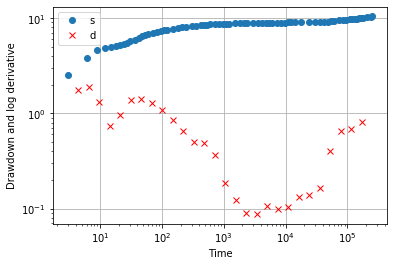

In [6]:
warrenvisual = ht.preprocessing(df=data)
warrenvisual.diagnostic()

In [7]:
e=400                   # Estimated reservoir thickness in m
rw=0.11                 # Radius of well in m
rc=0.11                 # Radius of casing in m
Q=3.58e-2               # Flow rate m3/s

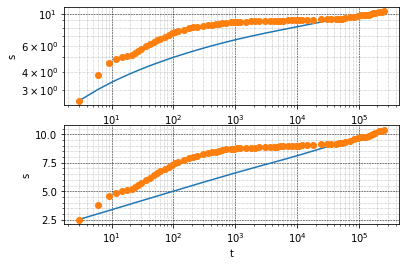

T =  0.003999904204262447 m2/s
S =  0.06537789204639012 -
Ri =  0.1247053103201647 m


In [8]:
warren = ht.WarrenRoot(Q=Q, r=rc, rw=rw, df=data)
warren.guess_params()
warren.trial()

`ftol` termination condition is satisfied.
Function evaluations 134, initial cost 8.6671e+01, final cost 2.5721e-01, first-order optimality 1.49e-06.


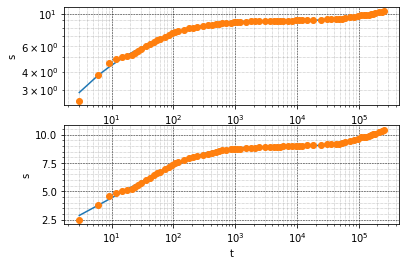

T =  0.0020945795633246986 m2/s
S =  0.15061363195105626 -
Ri =  1.9940087600498786 m


In [9]:
warren.fit_approximation(fitmethod='lm')
warren.trial()

`xtol` termination condition is satisfied.
Function evaluations 15, initial cost 2.7727e-01, final cost 2.7065e-01, first-order optimality 1.24e-02.


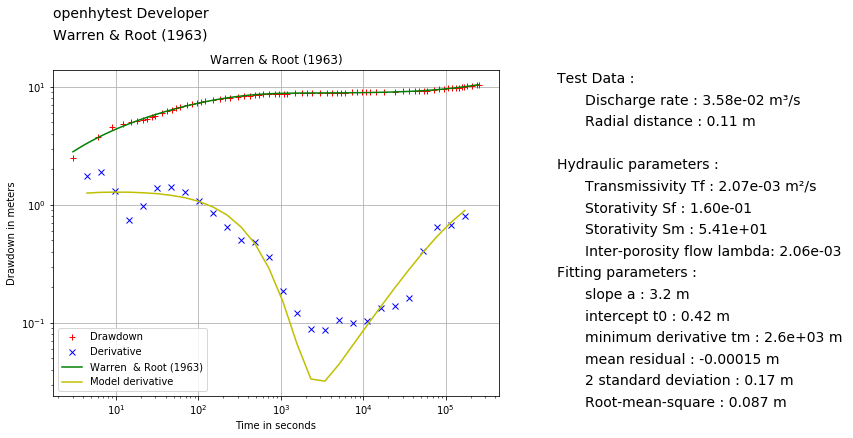

In [10]:
warren.rpt(fitmethod='trf', ttle='Warren & Root (1963)', author='openhytest Developer', filetype='pdf', reptext='Report_YuccaMountain_example')

The data do not allow to fit the Warren & Root model directly. That's why we first fitted the asymptotic approximation to the data and then using the real model.  

The results are in reasonable agreement with the values found by Moench (1984):
T = 3.3 E-3 m2/s
